In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

### Outlier Detection
We detected outliers using the interquartile range criterion. For each numeric column (TV, Radio, Newspaper, Sales), we computed Q1, Q3 and IQR = Q3 − Q1. Values outside [Q1 − 1.5 × IQR, Q3 + 1.5 × IQR] were flagged as outliers. We reported the count of outliers per column and created a clean subset by removing rows containing at least one outlier. Modeling was performed on the clean subset to reduce the impact of extreme values.


In [13]:
df = pd.read_csv('advertising.csv')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [15]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

print("IQR:\n", IQR)

IQR:
 TV           144.45
Radio         26.55
Newspaper     32.35
Sales          8.05
dtype: float64


In [16]:
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers = ((df < lower_limit) | (df > upper_limit))
outliers.sum()

TV           0
Radio        0
Newspaper    2
Sales        0
dtype: int64

In [17]:
df_outliers = df[outliers.any(axis=1)]
df_outliers

,TV,Radio,Newspaper,Sales
16,67.8,36.6,114.0,12.5
101,296.4,36.3,100.9,23.8


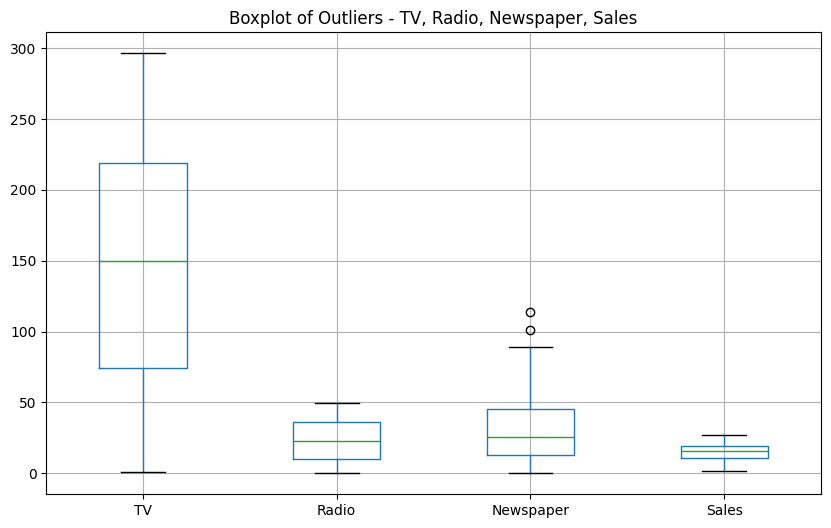

In [20]:
df.boxplot(figsize=(10,6))
plt.title("Boxplot of Outliers - TV, Radio, Newspaper, Sales")
plt.show()

In [21]:
df_clean = df[~outliers.any(axis=1)]
print("Before:", len(df))
print("After removing outliers:", len(df_clean))

Before: 200
After removing outliers: 198


### Split 60/40 vs 90/10 (All Features)
We compared two splits using all predictors (TV, Radio, Newspaper).

- 60/40 uses a larger test set, which provides a more reliable estimate of generalization.
- 90/10 provides more training data and may produce slightly better scores, although with a smaller and less stable test estimate.


In [24]:
X = df[['TV', 'Radio', 'Newspaper']]  # independent variables
y = df['Sales']                        # dependent variable

X_train_60, X_test_40, y_train_60, y_test_40 = train_test_split(
    X, y, test_size=0.4, random_state=42
)

model_60 = LinearRegression()
model_60.fit(X_train_60, y_train_60)

y_pred_40 = model_60.predict(X_test_40)

mae_60 = mean_absolute_error(y_test_40, y_pred_40)
mse_60 = mean_squared_error(y_test_40, y_pred_40)
rmse_60 = np.sqrt(mse_60)
r2_60 = r2_score(y_test_40, y_pred_40)

In [25]:
X_train_90, X_test_10, y_train_90, y_test_10 = train_test_split(
    X, y, test_size=0.1, random_state=42
)

model_90 = LinearRegression()
model_90.fit(X_train_90, y_train_90)

y_pred_10 = model_90.predict(X_test_10)

mae_90 = mean_absolute_error(y_test_10, y_pred_10)
mse_90 = mean_squared_error(y_test_10, y_pred_10)
rmse_90 = np.sqrt(mse_90)
r2_90 = r2_score(y_test_10, y_pred_10)

In [26]:
results = {
    "60/40 Split": [mae_60, mse_60, rmse_60, r2_60],
    "90/10 Split": [mae_90, mse_90, rmse_90, r2_90],
}

comparison = pd.DataFrame(results, index=["MAE", "MSE", "RMSE", "R²"])
print(comparison)

      60/40 Split  90/10 Split
MAE      1.228792     1.404681
MSE      2.713287     2.858380
RMSE     1.647206     1.690675
R²       0.901592     0.912542


**Conclusion for Splits**  
The 90/10 split often yields marginally higher R² and lower RMSE due to more training data. However, the 60/40 split offers a more trustworthy evaluation because of its larger test set. Therefore, while 90/10 may appear better numerically, 60/40 is more reliable for reporting.

### Drop-One-Feature Experiments
We built three models by dropping one feature at a time and evaluated them with a fixed 20 percent test split:

1. TV + Radio → Sales  
2. TV + Newspaper → Sales  
3. Radio + Newspaper → Sales

**Conclusion for Feature Sets**  
The combination **TV + Radio** consistently achieves the highest R² and the lowest error metrics, indicating the best predictive performance. Combinations that include **Newspaper** underperform relative to TV + Radio. This suggests that Newspaper contributes limited additional predictive power compared with TV and Radio.

In [27]:
def evaluate_model(X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    return mae, mse, rmse, r2

In [29]:
X1 = df[['TV', 'Radio']]
y = df['Sales']

mae1, mse1, rmse1, r2_1 = evaluate_model(X1, y)

X2 = df[['TV', 'Newspaper']]

mae2, mse2, rmse2, r2_2 = evaluate_model(X2, y)

X3 = df[['Radio', 'Newspaper']]

mae3, mse3, rmse3, r2_3 = evaluate_model(X3, y)

In [30]:
comparison = pd.DataFrame({
    "TV + Radio": [mae1, mse1, rmse1, r2_1],
    "TV + Newspaper": [mae2, mse2, rmse2, r2_2],
    "Radio + Newspaper": [mae3, mse3, rmse3, r2_3]
}, index=["MAE", "MSE", "RMSE", "R²"])

print(comparison)

      TV + Radio  TV + Newspaper  Radio + Newspaper
MAE     1.267042        1.947380           4.582491
MSE     2.846616        6.396605          27.500632
RMSE    1.687192        2.529151           5.244104
R²      0.907880        0.792998           0.110044


### Final Recommendation
Use **TV and Radio** as the primary predictors for Sales. Report both split settings for completeness, but emphasize the **60/40 scores** as the more reliable generalization estimate and note that **90/10** can slightly improve apparent fit due to more training data.